In [180]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [91]:
df = pd.read_csv('train.csv')

In [92]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [94]:
df_copy = df.copy()

In [95]:
#Street Column to dummies as it only contains 2 different categories
df_copy = pd.get_dummies(df_copy, columns=['Street'], drop_first=True)

In [96]:
#Dropping columns with +20% nulls
df_copy.drop(columns=['Alley','PoolQC', 'Fence', 'MiscFeature'], inplace=True)

In [97]:
#Lot Shape to numeric
df_copy['LotShape'] = df_copy['LotShape'].replace(['IR3', 'IR2', 'IR1', 'Reg'],
                        [0, 1, 2, 3])

In [98]:
#Land contour to numeric infering leveled is best 
df_copy['LandContour'] = df_copy['LandContour'].replace(['Low', 'HLS', 'Bnk', 'Lvl'],
                        [0, 1, 2, 3])

In [99]:
#Utilities to numeric
df_copy['Utilities'] = df_copy['Utilities'].replace(['ELO', 'NoSeWa', 'NoSewr', 'AllPub'],
                        [0, 1, 2, 3])

In [101]:
#LotConfig to dummies
df_copy = pd.get_dummies(df_copy, columns=['LotConfig'], drop_first=True)

In [103]:
#LandSlope to numeric
df_copy['LandSlope'] = df_copy['LandSlope'].replace(['Sev', 'Mod', 'Gtl'],
                        [0, 1, 2])

In [113]:
df_copy.groupby('LandSlope')['SalePrice'].mean()

LandSlope
0    204379.230769
1    196734.138462
2    179956.799566
Name: SalePrice, dtype: float64

In [106]:
#Neighborhood to dummies
df_copy = pd.get_dummies(df_copy, columns=['Neighborhood'])

In [117]:
# Dropping Condition1 and Condition2 as most are normal +90%
#df_copy.Condition1.value_counts()
#df_copy.Condition2.value_counts()
df_copy.drop(columns=['Condition1','Condition2'], inplace=True)

In [122]:
#Type of Dweling to dummies
df_copy = pd.get_dummies(df_copy, columns=['BldgType'])

In [127]:
# HouseStyle to dummies
df_copy = pd.get_dummies(df_copy, columns=['HouseStyle'])

KeyError: "None of [Index(['HouseStyle'], dtype='object')] are in the [columns]"

In [126]:
# Add house age and since remodel
df['age'] = df['YrSold'] - df['YearBuilt']
df['age_remodel'] = df['YrSold'] - df['YearRemodAdd']


In [138]:
#Review roof and Experiors and dropping (high standard deviation)
df.RoofMatl.value_counts()
df.RoofStyle.value_counts()
df.Exterior1st.value_counts()
#df.Exterior2nd.value_counts()
#df_copy.groupby('Exterior1st')['SalePrice'].agg(['mean', 'std'])
df_copy.drop(columns=['RoofMatl','RoofStyle', 'Exterior1st', 'Exterior2nd'], inplace=True)

In [140]:
#Review Masonry veneer and dropping (high standard deviation)
df_copy.groupby('MasVnrType')['SalePrice'].agg(['mean', 'std'])
df_copy.drop(columns=['MasVnrType'], inplace=True)

In [142]:
#All Quality to Numeric
df_copy.ExterQual = df_copy.ExterQual.fillna('None').replace(['None','Po', 'Fa', 'TA', 'Gd', 'Ex'],[0, 1, 2, 3, 4, 5])
df_copy.ExterCond = df_copy.ExterCond.fillna('None').replace(['None','Po', 'Fa', 'TA', 'Gd', 'Ex'],[0, 1, 2, 3, 4, 5])
df_copy.BsmtQual = df_copy.BsmtQual.fillna('None').replace(['None','Po', 'Fa', 'TA', 'Gd', 'Ex'],[0, 1, 2, 3, 4, 5])
df_copy.BsmtCond = df_copy.BsmtCond.fillna('None').replace(['None','Po', 'Fa', 'TA', 'Gd', 'Ex'],[0, 1, 2, 3, 4, 5])
df_copy.HeatingQC = df_copy.HeatingQC.fillna('None').replace(['None','Po', 'Fa', 'TA', 'Gd', 'Ex'],[0, 1, 2, 3, 4, 5])
df_copy.KitchenQual = df_copy.KitchenQual.fillna('None').replace(['None','Po', 'Fa', 'TA', 'Gd', 'Ex'],[0, 1, 2, 3, 4, 5])
df_copy.FireplaceQu = df_copy.FireplaceQu.fillna('None').replace(['None','Po', 'Fa', 'TA', 'Gd', 'Ex'],[0, 1, 2, 3, 4, 5])
df_copy.GarageQual = df_copy.GarageQual.fillna('None').replace(['None','Po', 'Fa', 'TA', 'Gd', 'Ex'],[0, 1, 2, 3, 4, 5])
df_copy.GarageCond = df_copy.GarageCond.fillna('None').replace(['None','Po', 'Fa', 'TA', 'Gd', 'Ex'],[0, 1, 2, 3, 4, 5])

In [144]:
df_copy = pd.get_dummies(df_copy, columns=['CentralAir'], drop_first=True)

In [145]:
df_copy.Electrical = df_copy.Electrical.fillna('None').replace(['None','Mix', 'FuseP', 'FuseF', 'FuseA', 'Sbrkr'],[0, 1, 2, 3, 4, 5])

In [146]:
df_copy.PavedDrive = df_copy.PavedDrive.fillna('None').replace(['None','N', 'P', 'Y'],[0, 1, 2, 3])

In [147]:
#Dropping columns I believe are already captured with above
df_copy.drop(columns=['Foundation','BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'Functional', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'SaleType', 'SaleCondition'], inplace=True)

In [149]:
df_copy['Num_bathrooms'] = df_copy.FullBath + df_copy.HalfBath*0.5 + df_copy.BsmtFullBath + df_copy.BsmtHalfBath*0.5


In [249]:
df_copy.MasVnrArea = df_copy.MasVnrArea.fillna(0)

<H1>Correlations</H1>

In [253]:
corr = pd.Series(df_copy.corr()['SalePrice'])
corr = abs(corr)
corr = corr.sort_values(ascending=False)
corr_high = corr.head(20)
corr_high

SalePrice               1.000000
OverallQual             0.790982
GrLivArea               0.708624
ExterQual               0.682639
KitchenQual             0.659600
GarageCars              0.640409
Num_bathrooms           0.631731
GarageArea              0.623431
TotalBsmtSF             0.613581
1stFlrSF                0.605852
BsmtQual                0.585207
FullBath                0.560664
TotRmsAbvGrd            0.533723
YearBuilt               0.522897
FireplaceQu             0.520438
YearRemodAdd            0.507101
MasVnrArea              0.472614
Fireplaces              0.466929
HeatingQC               0.427649
Neighborhood_NridgHt    0.402149
Name: SalePrice, dtype: float64

<H1>Visualizations</H1>

In [254]:
def scatter(a, h = None):
    sns.scatterplot(x = a, y = 'SalePrice', hue= h, data = df )
    plt.title(f'Sale Price vs. {a}')
    plt.ylabel('Sale Price')
    plt.xlabel(f'{a}')
    return plt.show()

def boxplot(a, b, rot = 0):
    sns.boxplot(x = a, y = b, data=df)
    plt.title(f'{b} vs. {a}')
    plt.ylabel(f'{b}')
    plt.xlabel(f'{a}')
    plt.xticks(rotation = rot)
    return plt.show()

In [255]:
reduced_df = df_copy.copy()
reduced_df = reduced_df[corr_high.index]

In [256]:
reduced_df.BsmtQual

0       4
1       4
2       4
3       3
4       4
       ..
1455    4
1456    4
1457    3
1458    3
1459    3
Name: BsmtQual, Length: 1460, dtype: int64

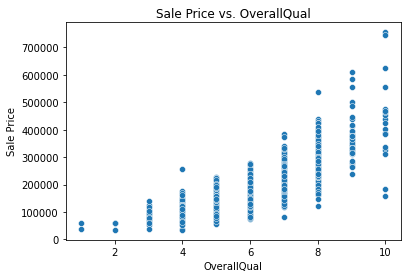

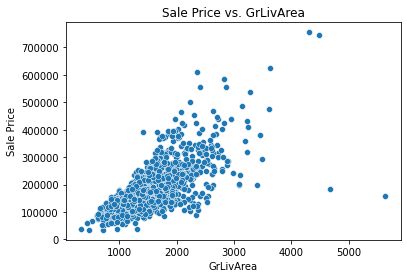

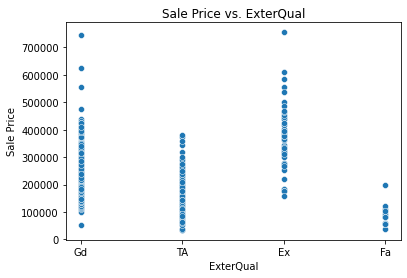

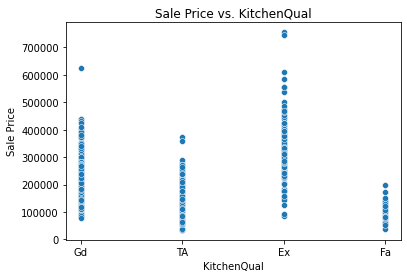

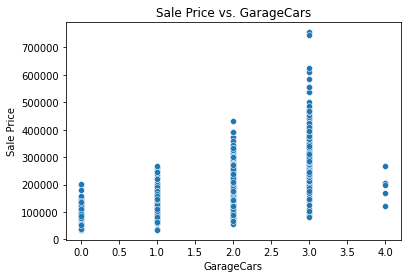

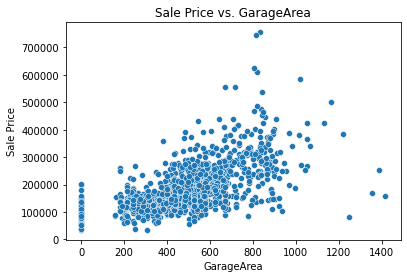

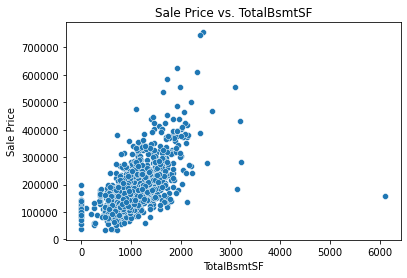

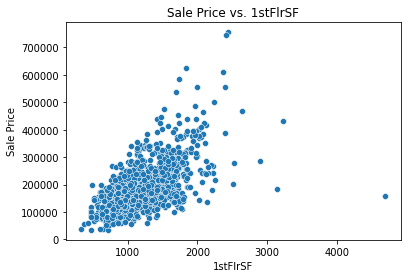

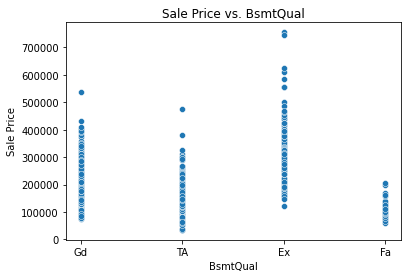

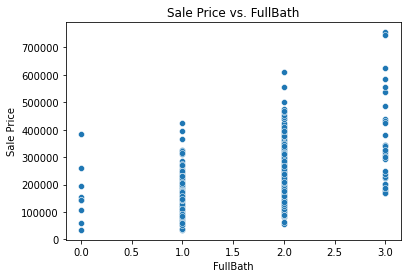

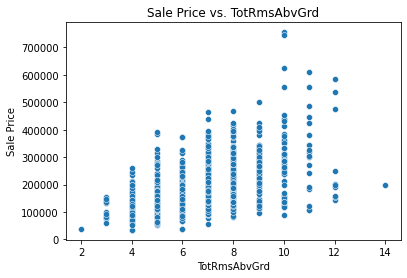

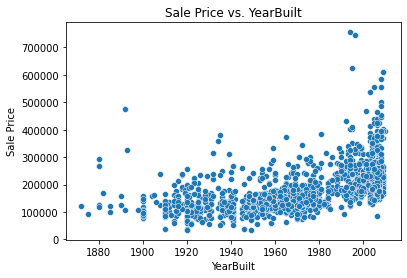

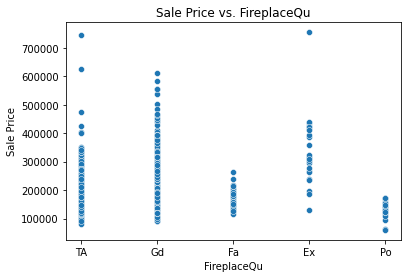

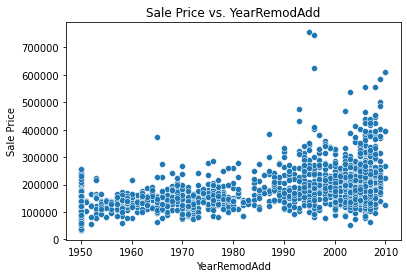

In [271]:
for col in reduced_df[cols_to_keep].drop(columns=['SalePrice', 'Num_bathrooms']).columns:
    scatter(col)

In [272]:
reduced_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   SalePrice             1460 non-null   int64  
 1   OverallQual           1460 non-null   int64  
 2   GrLivArea             1460 non-null   int64  
 3   ExterQual             1460 non-null   int64  
 4   KitchenQual           1460 non-null   int64  
 5   GarageCars            1460 non-null   int64  
 6   Num_bathrooms         1460 non-null   float64
 7   GarageArea            1460 non-null   int64  
 8   TotalBsmtSF           1460 non-null   int64  
 9   1stFlrSF              1460 non-null   int64  
 10  BsmtQual              1460 non-null   int64  
 11  FullBath              1460 non-null   int64  
 12  TotRmsAbvGrd          1460 non-null   int64  
 13  YearBuilt             1460 non-null   int64  
 14  FireplaceQu           1460 non-null   int64  
 15  YearRemodAdd         

In [258]:
#OLS Regression Model
X = sm.add_constant(reduced_df.drop(columns=['SalePrice']))
Y = reduced_df.SalePrice

model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     316.5
Date:                Wed, 09 Feb 2022   Prob (F-statistic):               0.00
Time:                        00:45:36   Log-Likelihood:                -17344.
No. Observations:                1460   AIC:                         3.473e+04
Df Residuals:                    1440   BIC:                         3.483e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -3.726e+05 

In [259]:
X = sm.add_constant(reduced_df.drop(columns=['SalePrice', 'GarageArea','TotalBsmtSF', 'TotRmsAbvGrd', 'YearBuilt', 'YearBuilt', 'FireplaceQu', 'YearRemodAdd', 'HeatingQC']))
Y = reduced_df.SalePrice

model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     499.9
Date:                Wed, 09 Feb 2022   Prob (F-statistic):               0.00
Time:                        00:48:20   Log-Likelihood:                -17348.
No. Observations:                1460   AIC:                         3.472e+04
Df Residuals:                    1447   BIC:                         3.479e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -1.384e+05 

In [261]:
X = reduced_df.drop(columns=['SalePrice', 'GarageArea','TotalBsmtSF', 'TotRmsAbvGrd', 'YearBuilt', 'YearBuilt', 'FireplaceQu', 'YearRemodAdd', 'HeatingQC'])
y = reduced_df.SalePrice

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=3)
reg = LinearRegression().fit(train_X, train_y)
reg_predictions = reg.predict(X)

In [262]:
reg.score(train_X, train_y)

0.8211358512031418

In [263]:
reg.score(test_X, test_y)

0.7366911849775388

In [264]:
#Lasso
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha = 15, max_iter=100, tol=0.1)
lasso_reg.fit(train_X, train_y)
lasso_predictions = lasso_reg.predict(X)

In [265]:
lasso_reg.score(train_X, train_y)

0.8169786422657316

In [266]:
lasso_reg.score(test_X, test_y)

0.7117776582905306

In [267]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha = 100, max_iter=100, tol=0.1)
ridge_reg.fit(train_X, train_y)
ridge_predictions = ridge_reg.predict(X)

In [268]:
ridge_reg.score(train_X, train_y)

0.8159030153771549

In [269]:
ridge_reg.score(test_X, test_y)

0.7365140637437231

<H1>Conclusion</H1>

The primary elements of the property that best predicts que price are:
1. Overall Quality
2. Above grade (ground) living area square feet
3. External Quality
4. Kitchen Quality
5. Garage Cars
6. Number of bathrooms
7. 1st floor square feet
8. Basement Quality
9. Full Bath
10. Masonry Veneer Area
11. Fireplaces
12. Location in NridgHt

In [273]:
print(print_model)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     499.9
Date:                Wed, 09 Feb 2022   Prob (F-statistic):               0.00
Time:                        00:48:20   Log-Likelihood:                -17348.
No. Observations:                1460   AIC:                         3.472e+04
Df Residuals:                    1447   BIC:                         3.479e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -1.384e+05 